<a href="https://colab.research.google.com/github/burcins/-Fine-Tuning-OpenAI-LLM/blob/master/F%C4%B0ne-Tune-OpenAI-LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome To The Notebook

### Task 1 - Set up the project environment

In [1]:
!pip install openai==1.7.2 python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00


Importing modules

In [2]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

In [3]:
load_dotenv("apikey.env.txt")
APIKEY = os.getenv("APIKEY")

Creating OpenAI Client

In [4]:
client = OpenAI(api_key = APIKEY)

### Task 2 - Prepare the training data

Loading the provided `Customer Complaints.csv`



In [6]:
training_data = pd.read_csv("Customer Complaints.csv")
training_data.head()

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."
3,Ridiculous prices for such terrible service! ...,"{""Topic"": ""Billing"", ""Problem"": ""Overcharged"",..."
4,Internet speed slower than a snail! Can't str...,"{""Topic"": ""Internet"", ""Problem"": ""Slow speed"",..."


In [7]:
training_data.iloc[0].Details

'{"Topic": "Internet", "Problem": "Unreliable service", "Customer_Dissatisfaction_Index": 90}'

**Converting the Complaints records to json**

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>

Let's get started!

Let's define a method that get's a row of the dataframe and convert it into the json format

In [8]:
def save_as_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Now let's use of this method to generate the `training_data.json`

In [9]:
for index, row in training_data.iterrows():
  save_as_json(row)

### Task 3 - Fine-tune GPT 3.5 based on our training data

Let's import the json file we prepared as our training data

In [10]:
data_file = client.files.create(
    file = open('training_data.json', 'rb'),
    purpose = 'fine-tune'
)
data_file

FileObject(id='file-re5kAKjsRFZg7SAYnEZ0HiEv', bytes=46722, created_at=1715885133, filename='training_data.json', object='file', purpose='fine-tune', status='processed', status_details=None)

Create the Fine Tuning Job

In [23]:
fine_tuning = client.fine_tuning.jobs.create(
    training_file= data_file.id,
    model = 'gpt-3.5-turbo',
    hyperparameters = {
        "n_epochs" : 'auto',
    }
)
fine_tuning

FineTuningJob(id='ftjob-lVVz0i7HzMl88dwFl6jitZ88', created_at=1715886085, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-5ComxuutKsT02INHkQ63j0Ec', result_files=[], status='validating_files', trained_tokens=None, training_file='file-re5kAKjsRFZg7SAYnEZ0HiEv', validation_file=None, user_provided_suffix=None, seed=911031212, estimated_finish=None, integrations=[])

Let's retrieve the state of the fine-tune

In [24]:
while True:
  time.sleep(2)
  retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning.id)
  status = retrieved_job.status
  print(status)

  if status == 'succeeded':
    print('Job is done')
    break

validating_files
queued
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


### Task 4 - Evaluate model

Let's retrieve the event messages to check out the learning process of our fine-tuning job.

In [25]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieved_job.id, limit=100).data

[FineTuningJobEvent(id='ftevent-P2EtGvHTO5WxjisCHwdY2KNQ', created_at=1715886501, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-ySqMGHGdTBJOdSuQY89Xs3bX', created_at=1715886499, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:onyx::9PakcPo0', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-3DQukdYe66Bh7cy9rHBvhAmz', created_at=1715886499, level='info', message='Checkpoint created at step 134 with Snapshot ID: ft:gpt-3.5-turbo-0125:onyx::9Pakczx4:ckpt-step-134', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-D2UBcI53Thi9AhrnKaRPsajk', created_at=1715886499, level='info', message='Checkpoint created at step 67 with Snapshot ID: ft:gpt-3.5-turbo-0125:onyx::9Pakc6Dl:ckpt-step-67', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-zSV0bJFh

Let's extract the training loss in each learning step

In [26]:
event = client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieved_job.id, limit=100)
for e in event:
  print(e.message)

The job has successfully completed
New fine-tuned model created: ft:gpt-3.5-turbo-0125:onyx::9PakcPo0
Checkpoint created at step 134 with Snapshot ID: ft:gpt-3.5-turbo-0125:onyx::9Pakczx4:ckpt-step-134
Checkpoint created at step 67 with Snapshot ID: ft:gpt-3.5-turbo-0125:onyx::9Pakc6Dl:ckpt-step-67
Step 201/201: training loss=0.06
Step 200/201: training loss=0.04
Step 199/201: training loss=0.00
Step 198/201: training loss=0.01
Step 197/201: training loss=0.12
Step 196/201: training loss=0.36
Step 195/201: training loss=0.28
Step 194/201: training loss=0.08
Step 193/201: training loss=0.13
Step 192/201: training loss=0.00
Step 191/201: training loss=0.01
Step 190/201: training loss=0.01
Step 189/201: training loss=0.11
Step 188/201: training loss=0.00
Step 187/201: training loss=0.15
Step 186/201: training loss=0.02
Step 185/201: training loss=0.00
Step 184/201: training loss=0.13
Step 183/201: training loss=0.03
Step 182/201: training loss=0.03
Step 181/201: training loss=0.06
Step 18

Use a line chart to visualize the train_loss in each step

In [27]:
steps = []
train_loss = []

for e in event:
  if e.data:
    steps.append(e.data['step'])
    train_loss.append(e.data['train_loss'])

In [28]:
print(steps)
print(train_loss)

[201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0.05842471122741699, 0.04181427136063576, 2.896344312830479e-06, 0.010410385206341743, 0.124814562499

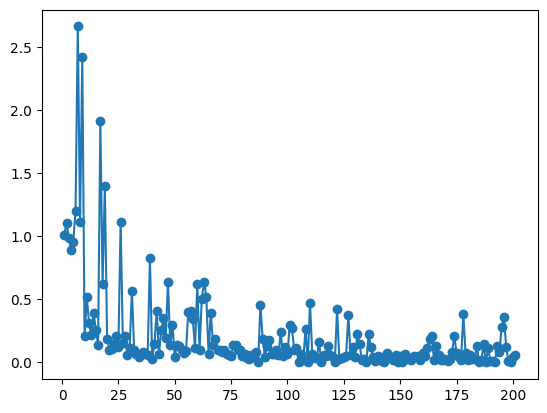

In [29]:
plt.plot(steps, train_loss, marker = 'o', linestyle = '-')

### Task 5 - Deploy our model

Let's take a look at `retrieved_job` again

In [30]:
myLLM = retrieved_job.fine_tuned_model
print(myLLM)

ft:gpt-3.5-turbo-0125:onyx::9PakcPo0


Defining a method to extract information from a given user complaint using a specific LLM and return the results.

In [31]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


Let's use our fine-tuned model to extract the details for the following user complaint:

*TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!*

In [34]:
complaint = "TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!"
extract_details(complaint, myLLM)

'{"Topic": "TV", "Problem": "Channels disappearing", "Customer_Dissatisfaction_Index": 10}'

Let's test our `GPT-4` model with the same user complaint

In [36]:
extract_details(complaint, 'gpt-4')

'{\n    "Topic": "Line Down",\n    "Problem": "Customer\'s line is down, causing disruptions",\n    "Customer_Dissatisfaction_Index": "High"\n}'

Let's try for the following complaint:

*Line is down! It is really annoying!*

In [35]:
complaint = "Line is down! It is really annoying!"
extract_details(complaint, myLLM)

'{"Topic": "Internet", "Problem": "Line down", "Customer_Dissatisfaction_Index": 10}'

Now let's compare the results from GPT-4

In [37]:
extract_details(complaint, 'gpt-4')

'{\n"Topic": "Line Down",\n"Problem": "The customer\'s line is down and they are finding it very annoying",\n"Customer_Dissatisfaction_Index": "High"\n}'

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.

In [38]:
customer_complaint = "I am very Angry! I want my money back!"
extract_details(complaint, myLLM)

'{"Topic": "Internet", "Problem": "Line down", "Customer_Dissatisfaction_Index": 10}'